# Data Preprocessing

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import json
import librosa
import soundfile as sf
import random
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm

In [8]:
DATASET_NAME = 'dataset'
AUDIO_SOURCE = '/home/giacomoschiavo/Tovanella'

In [9]:
DATASET_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}'
TRAIN_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}/train'
VALID_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}/valid'
TEST_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}/test'

In [23]:
species_list = set(os.listdir(TEST_PATH)).intersection(set(os.listdir(TRAIN_PATH)))

In [15]:
def print_dataset_count_table(dataset_path):
    train_folder = f"{dataset_path}/train"
    valid_folder = f"{dataset_path}/valid"
    test_folder = f"{dataset_path}/test"

    dataset_count = {}
    for species in os.listdir(test_folder):
        dataset_count[species] = {
            "train": len(os.listdir(os.path.join(train_folder, species))) if os.path.exists(os.path.join(train_folder, species)) else 0,
            "valid": len(os.listdir(os.path.join(valid_folder, species))) if os.path.exists(os.path.join(valid_folder, species)) else 0,
            "test": len(os.listdir(os.path.join(test_folder, species))) if os.path.exists(os.path.join(test_folder, species)) else 0
        }

    dataset_species_count_df = pd.DataFrame.from_dict(dataset_count, orient='index')
    dataset_species_count_df.index.name = 'Species'
    return dataset_species_count_df.sort_values(by=["test"], ascending=False)


In [16]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,15257,0,5116
Fringilla coelebs_Common Chaffinch,7310,0,981
Phylloscopus collybita_Common Chiffchaff,2172,0,669
Erithacus rubecula_European Robin,1616,0,549
Sylvia atricapilla_Eurasian Blackcap,3782,0,487
Turdus merula_Eurasian Blackbird,728,0,307
Regulus ignicapilla_Common Firecrest,3172,0,231
Wind,411,0,146
Troglodytes troglodytes_Eurasian Wren,1361,0,111


In [6]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,15257,0,5116
Fringilla coelebs_Common Chaffinch,7310,0,981
Sylvia atricapilla_Eurasian Blackcap,3782,0,487
Regulus ignicapilla_Common Firecrest,3172,0,231
Phylloscopus collybita_Common Chiffchaff,2172,0,669
Erithacus rubecula_European Robin,1616,0,549
Troglodytes troglodytes_Eurasian Wren,1361,0,111
Periparus ater_Coal Tit,993,0,20
Anthus trivialis_Tree Pipit,803,0,17


# Data division
How the segments are automatically split into training and test set

In [ ]:
# # # LOAD
# with open(f"utils/{DATASET_NAME}/species_date_count.json") as f:
#     species_date_count = json.load(f)

Get the count by date in each species

In [24]:
# get date count by species
target = f'{DATASET_PATH}/train'
species_date_count = {}
for species in species_list:
    if target not in species_date_count:
        species_date_count[species] = {}
    audio_names = os.listdir(os.path.join(target, species))
    date_counts = { audio.split("_")[0]: 0 for audio in audio_names }
    for date in date_counts:
        species_date_count[species][date] = { "count": sum(date in audio for audio in audio_names), "is_training": False, "is_test": False}

In [14]:
# with open(f"utils/{DATASET_NAME}/species_date_count.json", 'w') as f:
#     json.dump(species_date_count, f)

In [22]:
species_in_test = os.listdir(f'{DATASET_PATH}/test')
species_in_train = os.listdir(f'{DATASET_PATH}/train')

In [23]:
# species ONLY in train, not in test
species_to_test = set(species_in_train).difference(species_in_test)
species_to_test

set()

In [17]:
# species in test and not present in train
set(species_in_test).difference(species_in_train)

set()

In [18]:
import copy
random_valid_species = []
manual_split = []
train_test_division = copy.deepcopy(species_date_count)
for species in train_test_division.keys():
    if species not in species_to_test:
        continue
    dates = list(train_test_division[species].keys())
    date_count = len(dates)
    values = [value["count"] for value in train_test_division[species].values()]
    if date_count <= 1:     # ignore
        print(f'{species} to be removed ❌')
        continue
    elif date_count == 2:
        random_valid_species.append(species)
        greatest_date = dates[np.argmax(values)]
        train_test_division[species][greatest_date]["is_training"] = True     # majority -> training
        lowest_date = dates[np.argmin(values)]
        train_test_division[species][lowest_date]["is_test"] = True     # minority -> test
    else:
        random_valid_species.append(species)
        manual_split.append(species)
        print(f'{species} needs a manual split! 👨‍🔧')

## Manual Split

In [19]:
manual_split

[]

In [20]:
# {'20190608': {'count': 51, 'is_training': False, 'is_test': False},
#  '20200217': {'count': 21, 'is_training': False, 'is_test': False},
#  '20200215': {'count': 3, 'is_training': False, 'is_test': False}}

train_test_division['Dryocopus martius_Black Woodpecker']['20190608']['is_training'] = True
train_test_division['Dryocopus martius_Black Woodpecker']['20200217']['is_test'] = True
train_test_division['Dryocopus martius_Black Woodpecker']['20190608']['is_training'] = True

KeyError: '20200217'

In [ ]:
# {'20190608': {'count': 2141, 'is_training': False, 'is_test': False},
#  '20190603': {'count': 2042, 'is_training': False, 'is_test': False},
#  '20190621': {'count': 58, 'is_training': False, 'is_test': False}}
train_test_division['Turdus philomelos_Song Thrush']['20190608']['is_training'] = True
train_test_division['Turdus philomelos_Song Thrush']['20190603']['is_training'] = True
train_test_division['Turdus philomelos_Song Thrush']['20190621']['is_test'] = True

# How to split data in training and test set?
+ 1 date: ignore
+ Only 2 dates: minority -> test, majority -> training
+ More than 2 dates: take the majority and calculate the sum of all the other dates; if the sum is greater than half majority, move the biggest element in the minority into the majority and check again the sum

In [51]:
for species in train_test_division.keys():
    if species in species_to_test:
        continue
    dates = list(train_test_division[species].keys())
    date_count = len(dates)
    values = [value["count"] for value in train_test_division[species].values()]
    if date_count <= 1:    
        train_test_division[species][dates[0]]['is_training'] = True
        random_valid_species.append(species)
        continue
    elif date_count == 2:
        greatest_date = dates[np.argmax(values)]
        train_test_division[species][greatest_date]["is_training"] = True
    else:
        greatest_value_index = np.argmax(values)
        greatest_value_date = dates[greatest_value_index]
        greatest_value = train_test_division[species][greatest_value_date]["count"]
        train_test_division[species][greatest_value_date]["is_training"] = True
        other_values = [value["count"] if value["is_training"] == False else 0 for value in train_test_division[species].values()]
        sum_other_values = sum(other_values)
        while sum_other_values > greatest_value / 3:
            greatest_value_index = np.argmax(other_values)
            greatest_value_date = dates[greatest_value_index]
            train_test_division[species][greatest_value_date]["is_training"] = True            
            sum_other_values -= train_test_division[species][greatest_value_date]["count"]

In [53]:
train_test_division['random_valid_species'] = random_valid_species

In [ ]:
# SAVE
# with open(f"utils/{DATASET_NAME}/train_test_division.json", 'w') as f:
#     json.dump(train_test_division, f)

# Split Representation

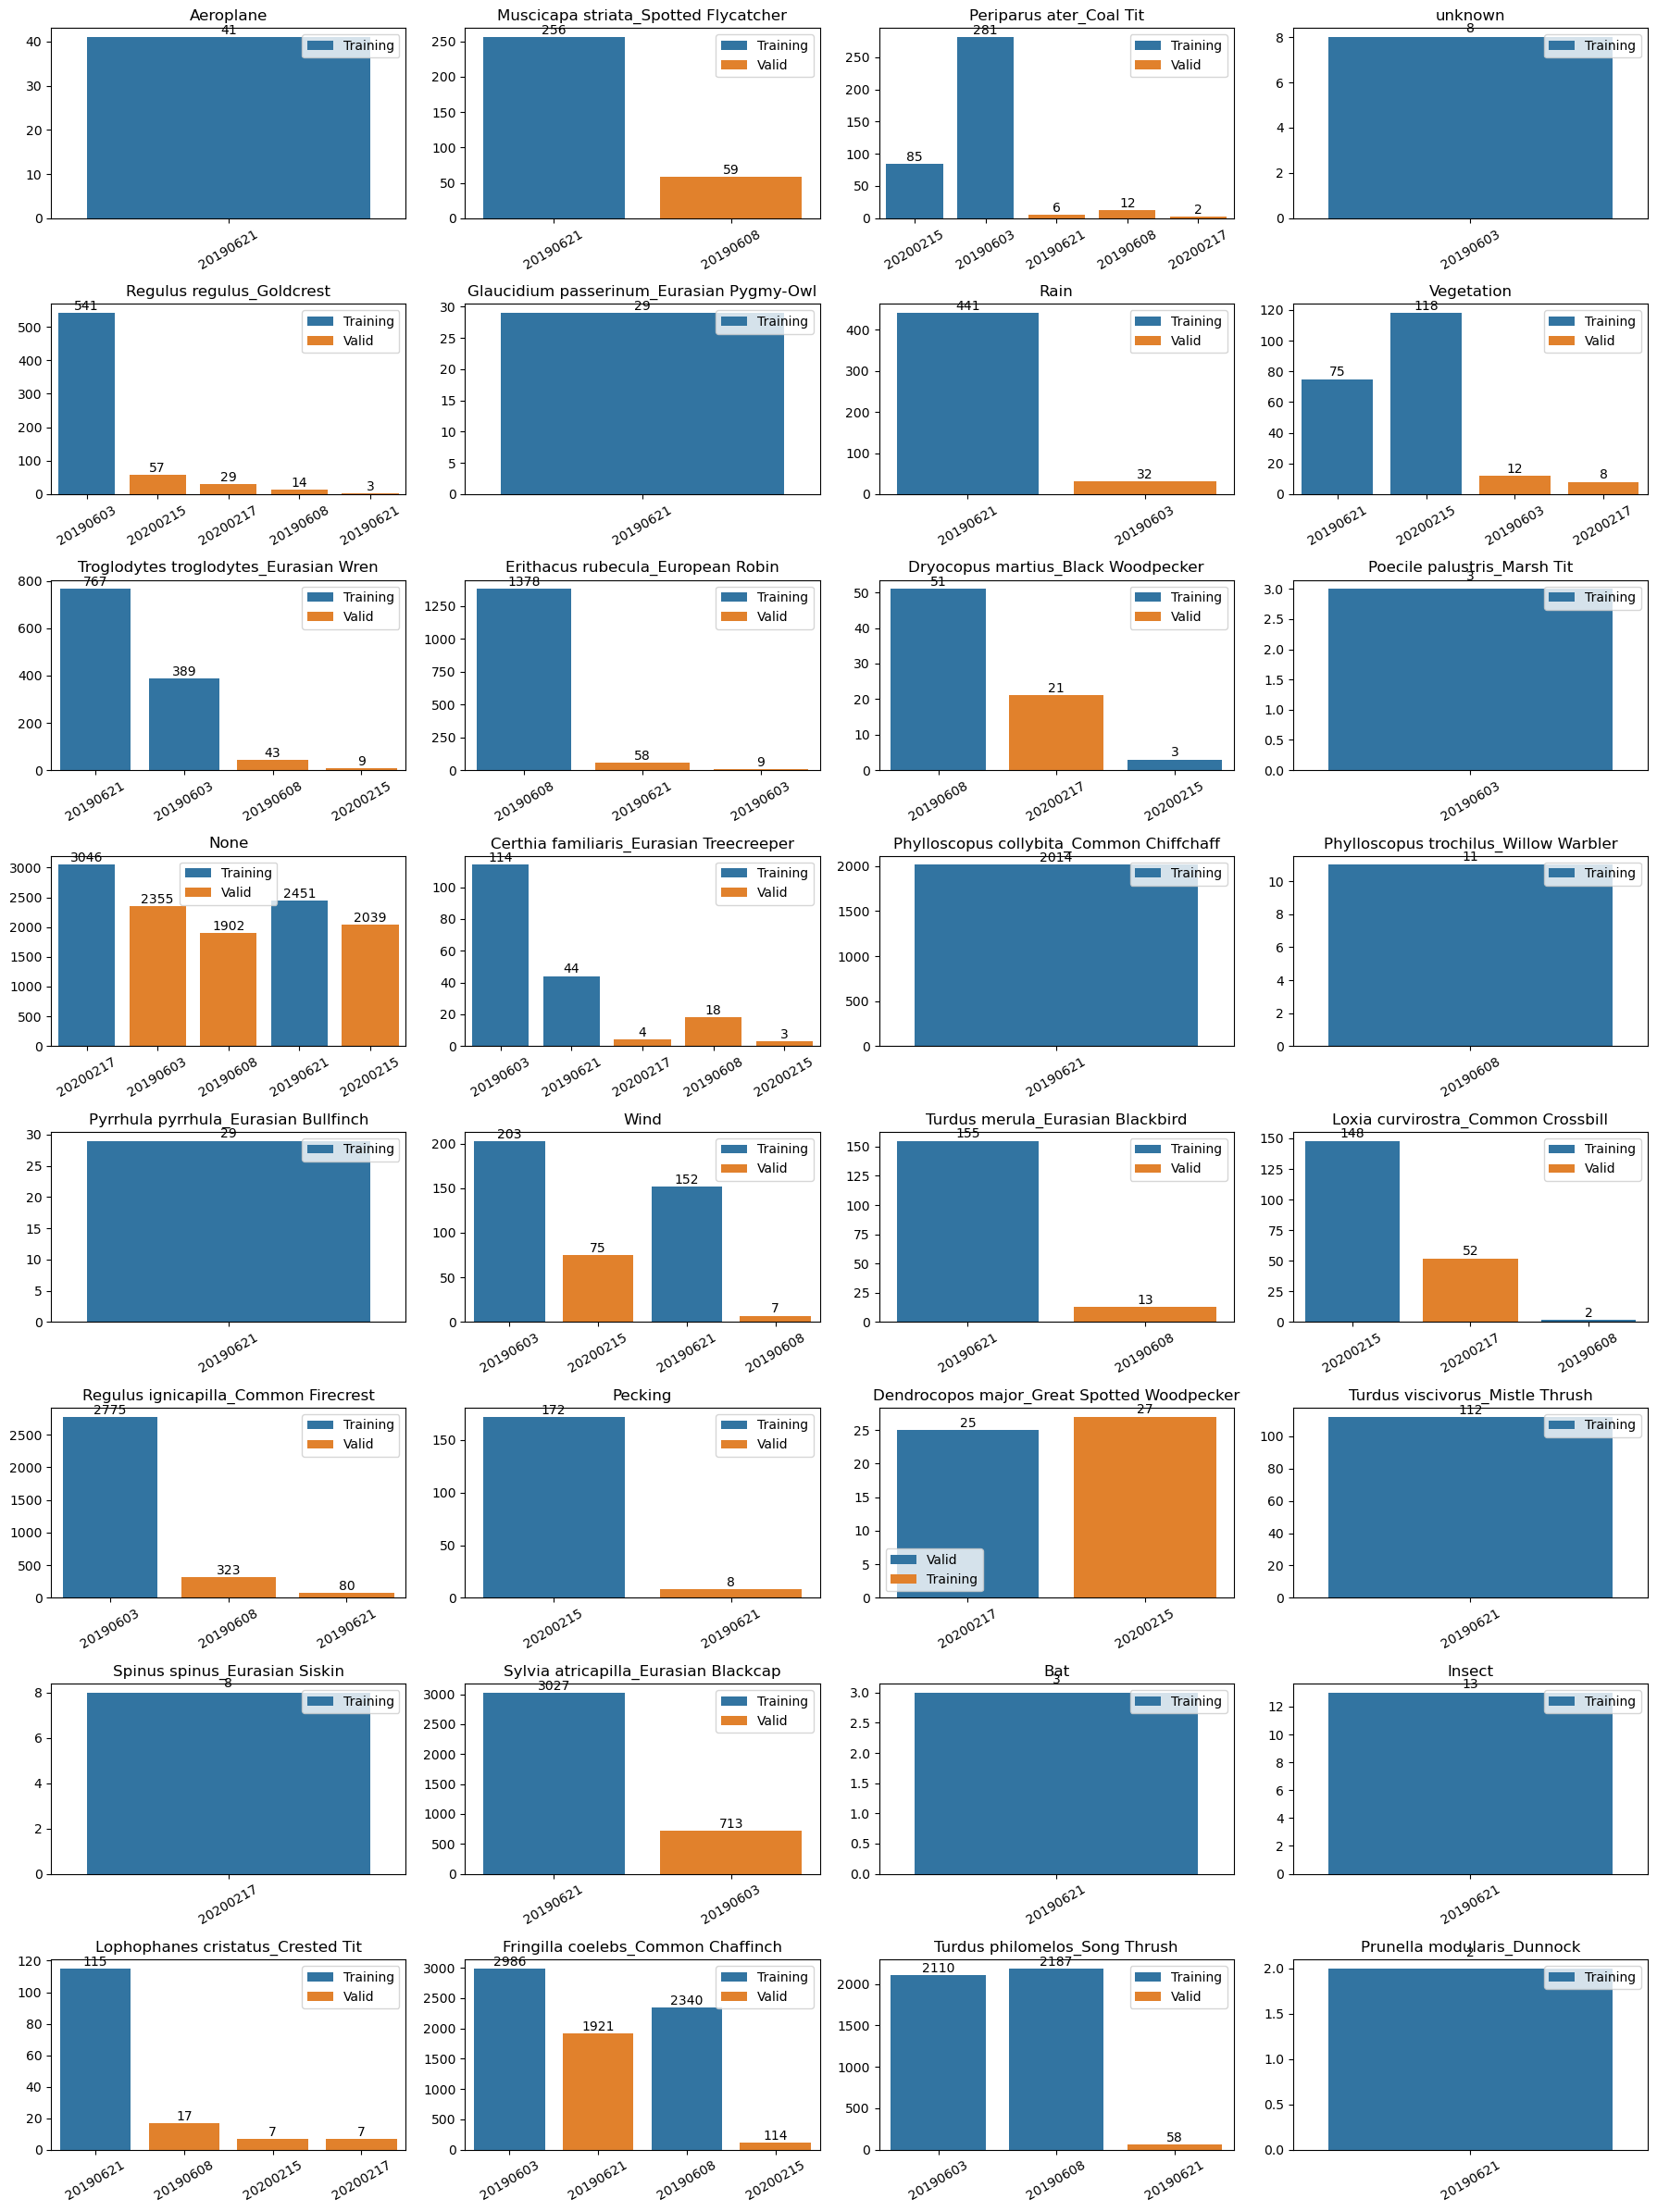

In [ ]:

# Supponiamo che 'species_date_count' contenga i tuoi dati
n_species = len(train_test_division.keys())

cols = 4
rows = (n_species // cols) + (n_species % cols != 0) 

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))
axes = axes.flatten()

for i, species in enumerate(train_test_division.keys()):
    dates = list(train_test_division[species].keys())
    counts = [value["count"] for value in train_test_division[species].values()]
    if len(dates) > 1:
        is_training = ["Training" if value["is_training"] else "Valid" for value in train_test_division[species].values()]
    else:
        is_training = ["Training"]
    sns.barplot(x=dates, y=counts, ax=axes[i], hue=is_training)

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.1, str(count), ha='center', va='bottom')
    axes[i].set_title(species)
    axes[i].tick_params(axis='x', rotation=30)  # Ruota le etichette sull'asse x se necessario

for i in range(n_species, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Aggiusta lo spazio tra i grafici
plt.show()


# Test set creation
Here we move the segments from the source (all the segments divided by species) to the test set, as the species_date_count describes 

In [55]:
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(VALID_PATH, exist_ok=True)

First, integrate the test set with the labels from the training set

In [56]:
for species in species_to_test:
    os.makedirs(os.path.join(TEST_PATH, species), exist_ok=True)
    dates = train_test_division[species].keys()
    if len(dates) == 1:
        print(f'{species} is ignored (not enough data)')
        continue
    for date in dates:
        if train_test_division[species][date]['is_test']:
            all_audio = [audio for audio in os.listdir(os.path.join(TRAIN_PATH, species)) if date in audio]
            for audio in all_audio:
                os.rename(
                    os.path.join(TRAIN_PATH, species, audio),
                    os.path.join(TEST_PATH, species, audio)
                )
            print(f'{species} is integrated in the test set!')


Turdus philomelos_Song Thrush is integrated in the test set!
Poecile palustris_Marsh Tit is ignored (not enough data)
Dryocopus martius_Black Woodpecker is integrated in the test set!
Rain is integrated in the test set!
Dendrocopos major_Great Spotted Woodpecker is integrated in the test set!
Bat is ignored (not enough data)
unknown is ignored (not enough data)
Glaucidium passerinum_Eurasian Pygmy-Owl is ignored (not enough data)
Loxia curvirostra_Common Crossbill is integrated in the test set!
Prunella modularis_Dunnock is ignored (not enough data)
Phylloscopus trochilus_Willow Warbler is ignored (not enough data)
Pyrrhula pyrrhula_Eurasian Bullfinch is ignored (not enough data)
Insect is ignored (not enough data)
Pecking is integrated in the test set!
Turdus viscivorus_Mistle Thrush is ignored (not enough data)


# Validation creation

Prendiamo sempre 1/5 random del training set. (80/20)

ATTENZIONE: siccome e' random, bisogna salvare in un file gli esempi spostati in modo da poter annullare lo spostamento 

In [57]:
random_valid_species

['Rain',
 'Dryocopus martius_Black Woodpecker',
 'Loxia curvirostra_Common Crossbill',
 'Pecking',
 'Dendrocopos major_Great Spotted Woodpecker',
 'Turdus philomelos_Song Thrush',
 'Aeroplane',
 'Phylloscopus collybita_Common Chiffchaff']

In [58]:
def move_random_valid(random_valid_species, train_path, valid_path, valid_ratio=0.2):
    np.random.seed(42)
    for species in random_valid_species:
        species_audio = os.listdir(os.path.join(train_path, species))
        selected_audio = np.random.choice(species_audio, int(len(species_audio) * valid_ratio), replace=False)
        species_dir_path = os.path.join(valid_path, species)
        if os.path.exists(species_dir_path):
            continue
        os.makedirs(species_dir_path, exist_ok=True)
        for audio in selected_audio:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(valid_path, species, audio)
            )


In [59]:
VALID_RATIO = 0.2
move_random_valid(random_valid_species, TRAIN_PATH, VALID_PATH, valid_ratio=VALID_RATIO)

In [60]:
def move_to_valid(train_test_division, train_path, valid_path):
    random_valid_species = train_test_division['random_valid_species']
    for species, dates in train_test_division.items():
        if species in random_valid_species:
            continue
        if isinstance(dates, list):     # ignores random_valid_species
            continue
        if len(dates) == 1:
            date_info = train_test_division[species][list(dates.keys())[0]] 
            print(species)
            if date_info['is_training'] is False:
                continue
        for date, info in dates.items():
            if info['is_training'] is False and info['is_test'] is False:   # move to valid
                species_dir_path = os.path.join(valid_path, species)
                if os.path.exists(species_dir_path):
                    continue
                os.makedirs(species_dir_path, exist_ok=True)
                for audio in os.listdir(os.path.join(train_path, species)):
                    if date in audio:
                        os.rename(
                            os.path.join(train_path, species, audio),
                            os.path.join(species_dir_path, audio)
                        )

In [61]:
move_to_valid(train_test_division, TRAIN_PATH, VALID_PATH)

unknown
Glaucidium passerinum_Eurasian Pygmy-Owl
Poecile palustris_Marsh Tit
Phylloscopus trochilus_Willow Warbler
Pyrrhula pyrrhula_Eurasian Bullfinch
Turdus viscivorus_Mistle Thrush
Bat
Insect
Prunella modularis_Dunnock


In [65]:
len(os.listdir(TRAIN_PATH)), len(os.listdir(TEST_PATH)), len(os.listdir(VALID_PATH))

(22, 22, 22)

Manteniamo solo le specie in cui sono presenti elementi nei tre set

In [63]:
valid_species = os.listdir(VALID_PATH)
REMOVED_PATH = f'{DATASET_PATH}/removed'
os.makedirs(REMOVED_PATH, exist_ok=True)
REMOVED_TRAIN_PATH = f'{REMOVED_PATH}/train'
os.makedirs(REMOVED_TRAIN_PATH, exist_ok=True)
for species in os.listdir(TRAIN_PATH):
    if species not in valid_species:
        os.makedirs(os.path.join(REMOVED_TRAIN_PATH, species), exist_ok=True)
        os.rename(
            os.path.join(TRAIN_PATH, species),
            os.path.join(REMOVED_TRAIN_PATH, species)
        )

In [64]:
valid_species = os.listdir(VALID_PATH)
REMOVED_TEST_PATH = f'{REMOVED_PATH}/test'
os.makedirs(REMOVED_TEST_PATH, exist_ok=True)
for species in os.listdir(TEST_PATH):
    if species not in valid_species:
        os.makedirs(os.path.join(REMOVED_TEST_PATH, species), exist_ok=True)
        os.rename(
            os.path.join(TEST_PATH, species),
            os.path.join(REMOVED_TEST_PATH, species)
        )

In [ ]:
    # for audio in os.listdir(os.path.join(TRAIN_PATH, species)):
    #     test_dates = [date for date in train_test_division[species].keys() 
    #                   if train_test_division[species][date]["is_training"] == False]
    #     audio_date = audio.split("_")[0]
    #     if audio_date in test_dates:
    #         source = os.path.join(TRAIN_PATH, species, audio)
    #         dest = os.path.join(TEST_PATH, species, audio)
    #         os.rename(source, dest)

In [ ]:
# # MOVE EVERYTHING BACK TO TRAINING
# train_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/train"
# test_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/test"
# valid_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/valid"
# removed = f"E:/Giacomo/Tovanella/{DATASET_NAME}/removed"

# for species in os.listdir(test_folder):
    # for audio in os.listdir(os.path.join(test_folder, species)):
    #     os.rename(
    #         os.path.join(test_folder, species, audio),
    #         os.path.join(train_folder, species, audio),
    #     )
# for species in os.listdir(removed):
#     os.rename(
#         os.path.join(removed, species),
#         os.path.join(train_folder, species),
#     )

# Sample Removal

In [69]:
train_folder = f"{DATASET_PATH}/train"
train_removed = f"{DATASET_PATH}/train_removed"

In [ ]:

for species in os.listdir(train_removed):
    all_audio = os.listdir(os.path.join(train_removed, species))
    for audio in all_audio:
        os.rename(
            os.path.join(train_removed, species, audio),
            os.path.join(train_folder, species, audio)
        )

In [73]:

for species in os.listdir(train_folder):
    if species != 'None':
        continue
    all_audio = os.listdir(os.path.join(train_folder, species))
    if len(all_audio) <= 100:
        continue
    random.shuffle(all_audio)
    os.makedirs(os.path.join(train_removed, species), exist_ok=True)
    chosen_audio = all_audio[:1000]
    for audio in all_audio:
        if audio in chosen_audio:
            continue
        print(species, audio)
        os.rename(
            os.path.join(train_folder, species, audio),
            os.path.join(train_removed, species, audio)
        )

None 20190621_010000_75_0.wav
None XC668297_0_61_5.wav
None 20190603_160000_450_0.wav
None 20200215_090000_49_5.wav
None 20190621_110000_120_0.wav
None 20190603_190000_499_5.wav
None XC870807_0_33_0.wav
None 20190607_110000_382_5.wav
None 20190621_210000_135_0.wav
None 20190621_210000_286_5.wav
None 20200217_000000_541_5.wav
None 20190603_160000_322_5.wav
None 20190607_080000_487_5.wav
None 20200217_070000_240_0.wav
None 20200217_110000_144_0.wav
None 20190603_160000_376_5.wav
None 20190621_020000_469_5.wav
None 20190603_170000_321_0.wav
None 20190603_140000_444_0.wav
None 20190603_050000_219_0.wav
None 20190603_090000_66_0.wav
None 20200215_090000_90_0.wav
None 20200215_110000_409_5.wav
None 20190603_170000_330_0.wav
None 20200215_090000_93_0.wav
None XC980998_0_4_5.wav
None 20200217_160000_282_0.wav
None 20200215_100000_541_5.wav
None 20200217_160000_228_0.wav
None 20190603_230000_276_0.wav
None 20190603_130000_177_0.wav
None 20200217_160000_76_5.wav
None 20190603_180000_132_0.wav
No

# WABAD Integration

In [26]:
train_folder = f"{DATASET_PATH}/train"
test_folder = f"{DATASET_PATH}/test"
WABAD_FOLDER = "/home/giacomoschiavo/WABAD/segments"

dataset_species_count = {}
for species in os.listdir(test_folder):
    dataset_species_count[species] = {
        "train": len(os.listdir(os.path.join(train_folder, species))),
        "test": len(os.listdir(os.path.join(test_folder, species))),
        "wabad": len(os.listdir(os.path.join(WABAD_FOLDER, species))) if os.path.exists(os.path.join(WABAD_FOLDER, species)) else 0
    }

wabad_species = os.listdir(WABAD_FOLDER)
dataset_species_count_df = pd.DataFrame.from_dict(dataset_species_count, orient='index')
dataset_species_count_df.index.name = 'Species'
dataset_species_count_df = dataset_species_count_df.reset_index() # Make 'Species' a regular column

dataset_species_count_df["In WABAD?"] = dataset_species_count_df["Species"].apply(lambda x: x in wabad_species)
dataset_species_count_df.sort_values(by="train", ascending=False)

,Species,train,test,wabad,In WABAD?
9,None,7000,5116,13345,True
20,Fringilla coelebs_Common Chaffinch,6662,981,0,False
21,Turdus philomelos_Song Thrush,4225,58,0,False
18,Sylvia atricapilla_Eurasian Blackcap,3196,487,0,False
15,Regulus ignicapilla_Common Firecrest,3054,231,0,False
11,Phylloscopus collybita_Common Chiffchaff,1780,669,0,False
7,Erithacus rubecula_European Robin,1407,549,0,False
6,Troglodytes troglodytes_Eurasian Wren,1189,111,0,False
3,Regulus regulus_Goldcrest,918,10,999,True
12,Wind,731,146,0,False


In [8]:
import random
WABAD_FOLDER = "/home/giacomoschiavo/WABAD/segments"

# MOVE WABAD TO TRAINING FOLDER
train_species = os.listdir(TRAIN_PATH)
for species in os.listdir(WABAD_FOLDER):
    if species not in train_species or species == "None":
        print(species)
        continue
    # select a maximum of 1000 segments per speciess
    all_audios = os.listdir(os.path.join(WABAD_FOLDER, species))[:4000]
    selected_audios = all_audios
        # selected_audios = random.sample(all_audios, NUM_SEGMENTS)
    for audio in selected_audios:
        os.rename(
            os.path.join(WABAD_FOLDER, species, audio),
            os.path.join(TRAIN_PATH, species, audio)
        )

None


## Undo WABAD

In [6]:
# move back
target_path = "/home/giacomoschiavo/WABAD/segments/"
for species in os.listdir(TRAIN_PATH):
    for audio in os.listdir(os.path.join(TRAIN_PATH, species)):
        if len(audio.split("_")[0]) <= 6:
            print(species, audio)
            os.rename(
                os.path.join(TRAIN_PATH, species, audio),
                os.path.join(target_path, species, audio)
            )

Muscicapa striata_Spotted Flycatcher SLOB_20230519_065500_22_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230520_054000_45_0.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230520_054000_48_0.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230519_065500_24_0.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230519_065500_52_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230519_065500_55_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230517_075500_7_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230518_084000_28_5.wav
Muscicapa striata_Spotted Flycatcher POZO_20230601_073000_31_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230518_084000_30_0.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230520_054000_46_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230519_065500_25_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230518_084000_33_0.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230518_084000_31_5.wav
Muscicapa striata_Spotted Flycatcher SLOB_20230517_075500_9_0.w

Turdus merula_Eurasian Blackbird CLH_20230505_212200_13_5.wav
Turdus merula_Eurasian Blackbird HAG_20190514_070000_13_5.wav
Turdus merula_Eurasian Blackbird DYOM_20230507_060102_40_5.wav
Turdus merula_Eurasian Blackbird HAG_20200528_130016_52_5.wav
Turdus merula_Eurasian Blackbird CAT_20210304_070300_1_5.wav
Turdus merula_Eurasian Blackbird CAT_20210304_064300_33_0.wav
Turdus merula_Eurasian Blackbird HAG_20200529_070003_34_5.wav
Turdus merula_Eurasian Blackbird MOPU_20180512_064642_16_5.wav
Turdus merula_Eurasian Blackbird VIL_20230509_071000_19_5.wav
Turdus merula_Eurasian Blackbird CAT_20210304_064200_34_5.wav
Turdus merula_Eurasian Blackbird PINA_20220502_080600_30_0.wav
Turdus merula_Eurasian Blackbird BIAL_20210420_061502_51_0.wav
Turdus merula_Eurasian Blackbird HAR_20220615_070702_4_5.wav
Turdus merula_Eurasian Blackbird SLOB_20230517_063300_39_0.wav
Turdus merula_Eurasian Blackbird VIL_20230509_071000_10_5.wav
Turdus merula_Eurasian Blackbird CAT_20210304_064200_37_5.wav
Turdu

In [37]:
dataset_species_count_wabad = {}
for species in os.listdir(test_folder):
    dataset_species_count_wabad[species] = {
        "train": len(os.listdir(os.path.join(train_folder, species))),
        "test": len(os.listdir(os.path.join(test_folder, species)))
    }
dataset_species_count_df = pd.DataFrame.from_dict(dataset_species_count_wabad, orient='index')
dataset_species_count_df.index.name = 'Species'
dataset_species_count_df.sort_values(by="train", ascending=False)


,train,test
Species,,
None,11000,5116
Fringilla coelebs_Common Chaffinch,6662,981
Regulus regulus_Goldcrest,5589,10
Periparus ater_Coal Tit,5491,20
Turdus merula_Eurasian Blackbird,5255,307
Turdus philomelos_Song Thrush,4225,58
Sylvia atricapilla_Eurasian Blackcap,3196,487
Regulus ignicapilla_Common Firecrest,3054,231
Certhia familiaris_Eurasian Treecreeper,1818,3


# Augmentation

In [28]:
# MOVE ALREADY CALCULATED AUGMENTATIONS
# REMOVED_PATH = f'{DATASET_PATH}/augm_removed'
# if os.path.exists(REMOVED_PATH):
#     for species in os.listdir(REMOVED_PATH):
#         for audio in os.listdir(os.path.join(REMOVED_PATH, species)):
#             print(species, audio)
#             os.rename(
#                 os.path.join(REMOVED_PATH, species, audio),
#                 os.path.join(TRAIN_PATH, species, audio)
#             )

In [29]:
import librosa
import soundfile as sf
from audiomentations import Compose, PitchShift, TimeStretch, AddBackgroundNoise, Gain

In [30]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def save_audio(file_path, audio, sr):
    sf.write(file_path, audio, sr)

In [31]:
bg_noise_path = f"{DATASET_PATH}/train_removed/None"
bg_noises = os.listdir(bg_noise_path)
augmentations = {
    "psA": Compose([PitchShift(min_semitones=-3, max_semitones=-1, p=0.75)]),
    "psB": Compose([PitchShift(min_semitones=1, max_semitones=3, p=0.75)]),
    "ts": Compose([TimeStretch(min_rate=0.9, max_rate=1.1, p=0.75)]),
    "bn": Compose([
        AddBackgroundNoise(sounds_path=os.path.join(bg_noise_path, random.choice(bg_noises)), p=0.8),
        Gain(min_gain_db=-5, max_gain_db=5, p=0.5) 
    ]),
}


def apply_augmentations(file_path, output_dir):
    audio, sr = load_audio(file_path)
    
    for aug_name, aug in augmentations.items():
        file_name = os.path.splitext(file_path)[0].split('/')[-1]
        if "aug" in file_name:
            continue
        save_audio_path = f"{output_dir}/{file_name}_aug_{aug_name}.wav"
        if os.path.exists(save_audio_path):
            continue
        augmented_audio = aug(samples=audio, sample_rate=sr)
        save_audio(save_audio_path, augmented_audio, sr)

In [33]:
# pick samples where validation samples == 0
train_folder = f'{DATASET_PATH}/train'
species_to_augment = []
threshold = 1000
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        print(species, "skipped")
        continue
    if len(os.listdir(os.path.join(train_folder, species))) >= threshold:
        continue
    species_to_augment.append(species)

species_to_augment

Aeroplane skipped
Rain skipped
Vegetation skipped
None skipped
Wind skipped
Pecking skipped


['Muscicapa striata_Spotted Flycatcher',
 'Periparus ater_Coal Tit',
 'Regulus regulus_Goldcrest',
 'Dryocopus martius_Black Woodpecker',
 'Certhia familiaris_Eurasian Treecreeper',
 'Turdus merula_Eurasian Blackbird',
 'Loxia curvirostra_Common Crossbill',
 'Dendrocopos major_Great Spotted Woodpecker',
 'Lophophanes cristatus_Crested Tit']

In [34]:
for species in species_to_augment:
    files = os.listdir(os.path.join(train_folder, species))
    print("Augmenting ", species)
    for i in tqdm(range(len(files)), colour="blue"):
        audio = files[i]
        apply_augmentations(os.path.join(train_folder, species, audio), os.path.join(train_folder, species))

Augmenting  Muscicapa striata_Spotted Flycatcher


100%|██████████| 256/256 [00:34<00:00,  7.36it/s]


Augmenting  Periparus ater_Coal Tit


100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


Augmenting  Regulus regulus_Goldcrest


100%|██████████| 918/918 [01:58<00:00,  7.74it/s]


Augmenting  Dryocopus martius_Black Woodpecker


 53%|█████▎    | 25/47 [00:02<00:02,  8.33it/s]/opt/conda/envs/myenv/lib/python3.10/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/giacomoschiavo/segments/dataset/train_removed/None/20200217_110000_39_0.wav had to be resampled from 48000 Hz to 44100 Hz. This hurt execution time.
  warnings.warn(
100%|██████████| 47/47 [00:05<00:00,  7.98it/s]


Augmenting  Certhia familiaris_Eurasian Treecreeper


100%|██████████| 324/324 [00:42<00:00,  7.56it/s]


Augmenting  Turdus merula_Eurasian Blackbird


100%|██████████| 251/251 [00:34<00:00,  7.37it/s]


Augmenting  Loxia curvirostra_Common Crossbill


100%|██████████| 119/119 [00:15<00:00,  7.78it/s]


Augmenting  Dendrocopos major_Great Spotted Woodpecker


100%|██████████| 23/23 [00:03<00:00,  6.82it/s]


Augmenting  Lophophanes cristatus_Crested Tit


100%|██████████| 138/138 [00:18<00:00,  7.66it/s]


In [35]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,7000,2098,5116
Fringilla coelebs_Common Chaffinch,6662,1918,981
Regulus regulus_Goldcrest,4590,57,10
Turdus philomelos_Song Thrush,4225,1056,58
Sylvia atricapilla_Eurasian Blackcap,3196,708,487
Regulus ignicapilla_Common Firecrest,3054,312,231
Periparus ater_Coal Tit,1875,6,20
Phylloscopus collybita_Common Chiffchaff,1780,402,669
Certhia familiaris_Eurasian Treecreeper,1620,4,3


## Augmentation removal

In [6]:
train_path = f"{DATASET_PATH}/train"
target_path = f"{DATASET_PATH}/augm_removed"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_path):
    for audio in os.listdir(os.path.join(train_path, species)):
        os.makedirs(os.path.join(target_path, species), exist_ok=True)
        if "aug" in audio:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(target_path, species, audio),
            )

In [7]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,7000,2098,5116
Fringilla coelebs_Common Chaffinch,6662,1918,981
Turdus philomelos_Song Thrush,4225,1056,58
Sylvia atricapilla_Eurasian Blackcap,3196,708,487
Regulus ignicapilla_Common Firecrest,3054,312,231
Phylloscopus collybita_Common Chiffchaff,1780,402,669
Erithacus rubecula_European Robin,1407,58,549
Troglodytes troglodytes_Eurasian Wren,1189,43,111
Regulus regulus_Goldcrest,918,57,10


# SNR Filter

In [3]:
def calculate_snr(audio_path):
    """
    Calculates the Signal-to-Noise Ratio (SNR) of an audio file with respect to a noise segment.

    - audio_path: path to the audio file
    - noise_start, noise_end: time interval in seconds where the noise is isolated
    """
    
    noise_audio = f"{DATASET_PATH}/None/20190603_110000_322_5.wav"
    y_noise, sr_noise = librosa.load(noise_audio, sr=None)
    
    noise_sample = y_noise[:]
    
    y, sr = librosa.load(audio_path, sr=None)
    signal_power = np.mean(y**2)
    noise_power = np.mean(noise_sample**2)
    
    if noise_power == 0:
        return np.inf
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [6]:
species_to_reduce = []
threshold = 200
train_folder = f'{DATASET_PATH}/train'
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        continue
    if len(os.listdir(os.path.join(train_folder, species))) <= threshold:
        continue
    species_to_reduce.append(species)

In [8]:
info = {}
for species in species_to_reduce:
    info[species] = {}
    for audio_path in os.listdir(os.path.join(train_folder, species)):
        full_audio_path = os.path.join(train_folder, species, audio_path)
        snr = calculate_snr(full_audio_path)
        info[species][audio_path] = snr

In [9]:
with open(f"utils/{DATASET_NAME}/audio_snr_info.json", "w") as f:
    json.dump(info, f)

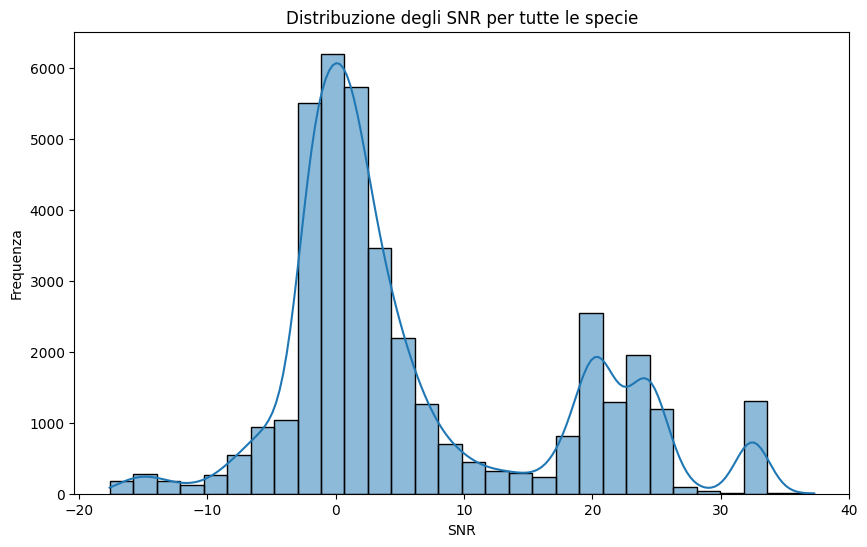

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Raccolta di tutti gli SNR in una lista unica
all_snr_values = []
for specie in info:
    all_snr_values.extend(info[specie].values())

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
sns.histplot(all_snr_values, bins=30, kde=True)

# Titoli e labels
plt.title("Distribuzione degli SNR per tutte le specie")
plt.xlabel("SNR")
plt.ylabel("Frequenza")

# Mostra il grafico
plt.show()


In [15]:
# Initialize the dictionary to store the results
top_800_per_specie = {}

# Iterate through each species in the 'info' dictionary
for species, files in info.items():
    # Filter files with SNR less than 20 dB
    snr_below_20 = {file: snr for file, snr in files.items() if snr < 20}
    
    # Sort the filtered files by SNR in descending order
    sorted_files = sorted(snr_below_20.items(), key=lambda item: item[1], reverse=True)
    
    # Select the first 800 files from the sorted list
    best_800 = [file for file, snr in sorted_files[:800]]
    
    # Add the species and the list of the best 800 files to the results dictionary
    top_800_per_specie[species] = best_800

# The 'top_800_per_specie' dictionary now contains species as keys
# and lists of the best 800 audio files with SNR less than 20 dB as values

In [22]:
target_path = f"{DATASET_PATH}/snr_removed"
train_path = f"{DATASET_PATH}/train"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_path):
    if species not in species_to_reduce:
        continue
    for audio in os.listdir(os.path.join(train_path, species)):
        os.makedirs(os.path.join(target_path, species), exist_ok=True)
        if audio not in top_800_per_specie[species]:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(target_path, species, audio)
            )


In [22]:
print_dataset_count_table()

,train,valid,test
Species,,,
Fringilla coelebs_Common Chaffinch,5402,600,2040
Turdus philomelos_Song Thrush,3886,431,58
Sylvia atricapilla_Eurasian Blackcap,2725,302,715
Regulus ignicapilla_Common Firecrest,2500,277,417
Erithacus rubecula_European Robin,1247,138,69
Troglodytes troglodytes_Eurasian Wren,1044,115,52
Regulus regulus_Goldcrest,495,55,106
Periparus ater_Coal Tit,286,31,116
Muscicapa striata_Spotted Flycatcher,231,25,64


### Undo SNR removal

In [4]:
import os
snr_folder_path = f"{DATASET_PATH}/snr_removed"
train_path = f"{DATASET_PATH}/train"
for species in os.listdir(snr_folder_path):
    for audio in os.listdir(os.path.join(snr_folder_path, species)):
        os.rename(
            os.path.join(snr_folder_path, species, audio),
            os.path.join(train_path, species, audio)
        )


### Undo WABAD from Train and Valid

In [ ]:
train_path = f"{DATASET_PATH}/train"
# valid_path = f"{DATASET_PATH}/valid"
wabad_segments = "E:/Giacomo/Tovanella/wabad_segments"

for species in os.listdir(train_path):
    for audio in os.listdir(os.path.join(train_path, species)):
        is_wabad = len(audio.split("_")[0]) != 8
        if is_wabad:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(wabad_segments, species, audio)
            )

### Undo Validation

In [18]:
train_path = f"{DATASET_PATH}/train"
valid_path = f"{DATASET_PATH}/valid"

for species in os.listdir(valid_path):
    for audio in os.listdir(os.path.join(valid_path, species)):
        os.rename(
            os.path.join(valid_path, species, audio),
            os.path.join(train_path, species, audio)
        )